# Step 2 : Pre-processing - Spatial filtering

Once you have download your datasets, you need to spatially filer them. You can filter dataset using a geometry. It can be a complexe geometry, with different polygones and with holes. I have dowload the geometries of Skagerrak, Kattegat and the Sweden Exclusive Economic Zone on the [Marine regions website](https://marineregions.org) as **.JSON**:
- [Sweden EEZ](https://www.marineregions.org/gazetteer.php?p=details&id=5694)
- [Kattegat](https://marineregions.org/gazetteer.php?p=details&id=2374)
- [Skagerrak](https://www.marineregions.org/gazetteer.php/gazetteer.php?p=details&id=2379)

I want my model to cover the all Sweden EEZ. But fisrt I will save time by developping it an a smaller region : the Living Lab West. That's why I need to combine the geometries of Kattegat and Skagerrak, then filter the combined geometry using the Sweden EEZ geometry.

#### Required Libraries
- `geopandas` for reading and manipulating spatial data.
- `shapely` for geometric operations like union and intersection.
- `fiona` which is used internally by geopandas to read .json files.
- `matplotlib` for visualyzing the data.
- `xarray` for reading datasets.
- `numpy` to extract the latitude and longitude colums.

In [18]:
import geopandas as gpd

In [19]:
# Load the geometries from the .json files
sweden_eez = gpd.read_file('sweden_eez.json')
kattegat = gpd.read_file('kattegat.json')
skagerrak = gpd.read_file('skagerrak.json')


Make sure the CRS (Coordinate Reference System) is the same for all datasets. If needed, you can reproject them to the same CRS. For example :

`sweden_eez = sweden_eez.to_crs(epsg=4326)`

C:\Users\PC\AppData\Local\Temp\ipykernel_3732\1573077448.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = kattegat.geometry.unary_union | skagerrak.geometry.unary_union  # Union of both geometries


<Axes: >

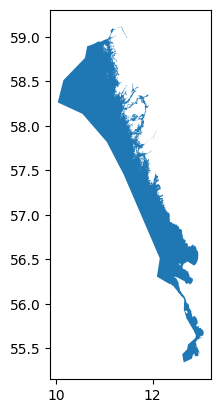

In [46]:
# Combine Kattegat and Skagerrak geometries
combined_geometry = kattegat.geometry.unary_union | skagerrak.geometry.unary_union  # Union of both geometries

# Filter the combined geometry using the Sweden EEZ (intersection)
filtered_geometry = sweden_eez.geometry.intersection(combined_geometry)

# Create a new GeoDataFrame with the filtered geometry
filtered_gdf = gpd.GeoDataFrame(geometry=filtered_geometry)

# Save the result to a new .json file
filtered_gdf.to_file('livinglab_west.json', driver='GeoJSON')

# Visualize the result
filtered_gdf.plot()

As you can see, we now have the geometry of the Living Lab ouest. Let's start filter our different datasets.

### Filtering the Zosteraceae dataset

In [30]:
import pandas as pd
from shapely.geometry import Point

In [47]:
# Load the geometry (the polygon) from the GeoJSON file
livinglab_geometry = gpd.read_file('livinglab_west.json')

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Artportalen-Zosteraceae.csv', delimiter ='\t')

print(df.columns)

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')


The spatial delimiter of the Artportalen dataset is a tab. We can identify the longitude and latitude columns : `'decimalLatitude'` and `'decimalLongitude'`

In [48]:
# Create a GeoDataFrame from the CSV by converting the latitude and longitude into geometries
plants = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf_plants = gpd.GeoDataFrame(df, geometry=plants)

# Make sure the CRS of Artportalen-Zosteraceae.csv matches the CRS of livinglab_ouest.json
gdf_plants = gdf_plants.set_crs('EPSG:4326', allow_override=True)

# Filter the points within the 'livinglab_ouest' geometry
filtered_gdf_plants = gdf_plants[gdf_plants.geometry.within(livinglab_geometry.unary_union)]

# Save the filtered data or work with it directly
filtered_gdf_plants.to_csv('filtered_Artportalen-Zosteraceae.csv', index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_3732\1857419964.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  filtered_gdf_plants = gdf_plants[gdf_plants.geometry.within(livinglab_geometry.unary_union)]


Let's visualise the data.

In [33]:
import matplotlib.pyplot as plt

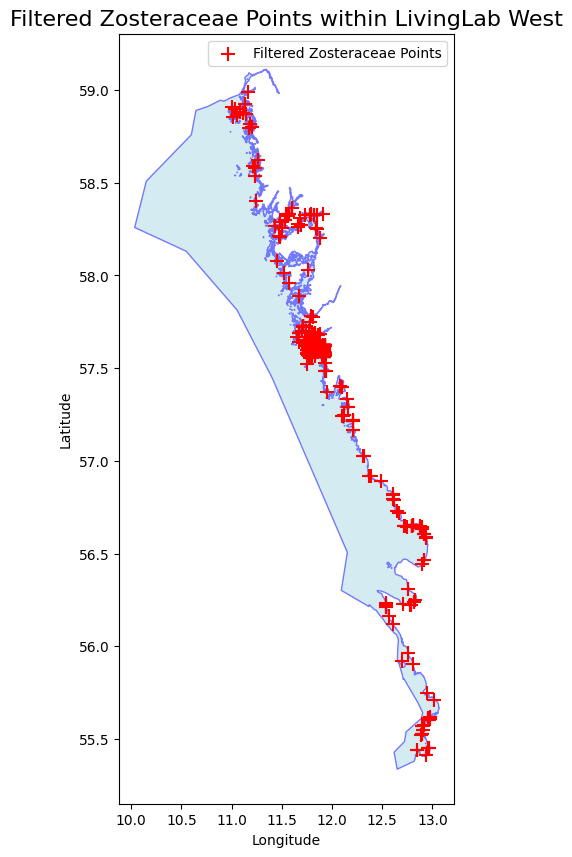

In [49]:
# Step 6: Plot the polygon and the filtered points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon (livinglab_ouest)
livinglab_geometry.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)

# Plot the filtered points using '+' markers
filtered_gdf_plants.plot(ax=ax, marker='+', color='red', markersize=100, label="Filtered Zosteraceae Points")

# Add title and labels
ax.set_title('Filtered Zosteraceae Points within LivingLab West', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show legend
ax.legend()

### Filtering the Baltic Sea Physics Reanalysis datset

Apply a spatial mask on a dataset is quite the same as apply it on a .csv file. We will used the `xarray` library to read the .nc files, and `numpy` to extract the latitude and longitude colums.

In [42]:
import xarray as xr
import numpy as np
from shapely.geometry import shape

## 

First, let's open one of the files and understand the structure of the file. In this file the longitude and columns names are `'lat'` and `'lon'`. There is also a column name `'depth'`

In [52]:
input_file = 'BAL-MYP-NEMO_PHY-AnnualMeans-2015.nc'
ds = xr.open_dataset(input_file)
ds

<xarray.Dataset> Size: 543MB
Dimensions:  (time: 1, lat: 774, lon: 763, depth: 56)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2015-07-01T06:00:00
Data variables:
    bottomT  (time, lat, lon) float32 2MB ...
    mlotst   (time, lat, lon) float32 2MB ...
    siconc   (time, lat, lon) float32 2MB ...
    sithick  (time, lat, lon) float32 2MB ...
    sla      (time, lat, lon) float32 2MB ...
    so       (time, depth, lat, lon) float32 132MB ...
    sob      (time, lat, lon) float32 2MB ...
    thetao   (time, depth, lat, lon) float32 132MB ...
    uo       (time, depth, lat, lon) float32 132MB ...
    vo       (time, depth, lat, lon) float32 132MB ...
Attributes: (12/21)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Tue Mar 07 17:51:07 2023: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    northernmost_latitude:  65.89099
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2015-01-01 12:00:00
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS NEMO annual integrated model fields

In [53]:
# Extract the coordinates from the NetCDF file
lat = ds['lat'].values
lon = ds['lon'].values

# Create a meshgrid of lat, lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create a 2D array of coordinates
coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

# Mask the points inside the livinglab ouest geometry
mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])

# Reshape the mask to match the grid of the dataset
mask = mask.reshape(lon_grid.shape)

# Create an xarray DataArray for the mask with the correct dimensions and coordinates
mask_da = xr.DataArray(mask, coords=[ds['lat'], ds['lon']], dims=["lat", "lon"])

# Apply the mask to the NetCDF data variables
filtered_data = ds.where(mask_da, drop=True)

Let's check the data by creating 2 functions : 
- `plot_2D_variable` for variables with latitude and longitude
- `plot_3D_variable` for variables with latitude, longitude and **depth**.

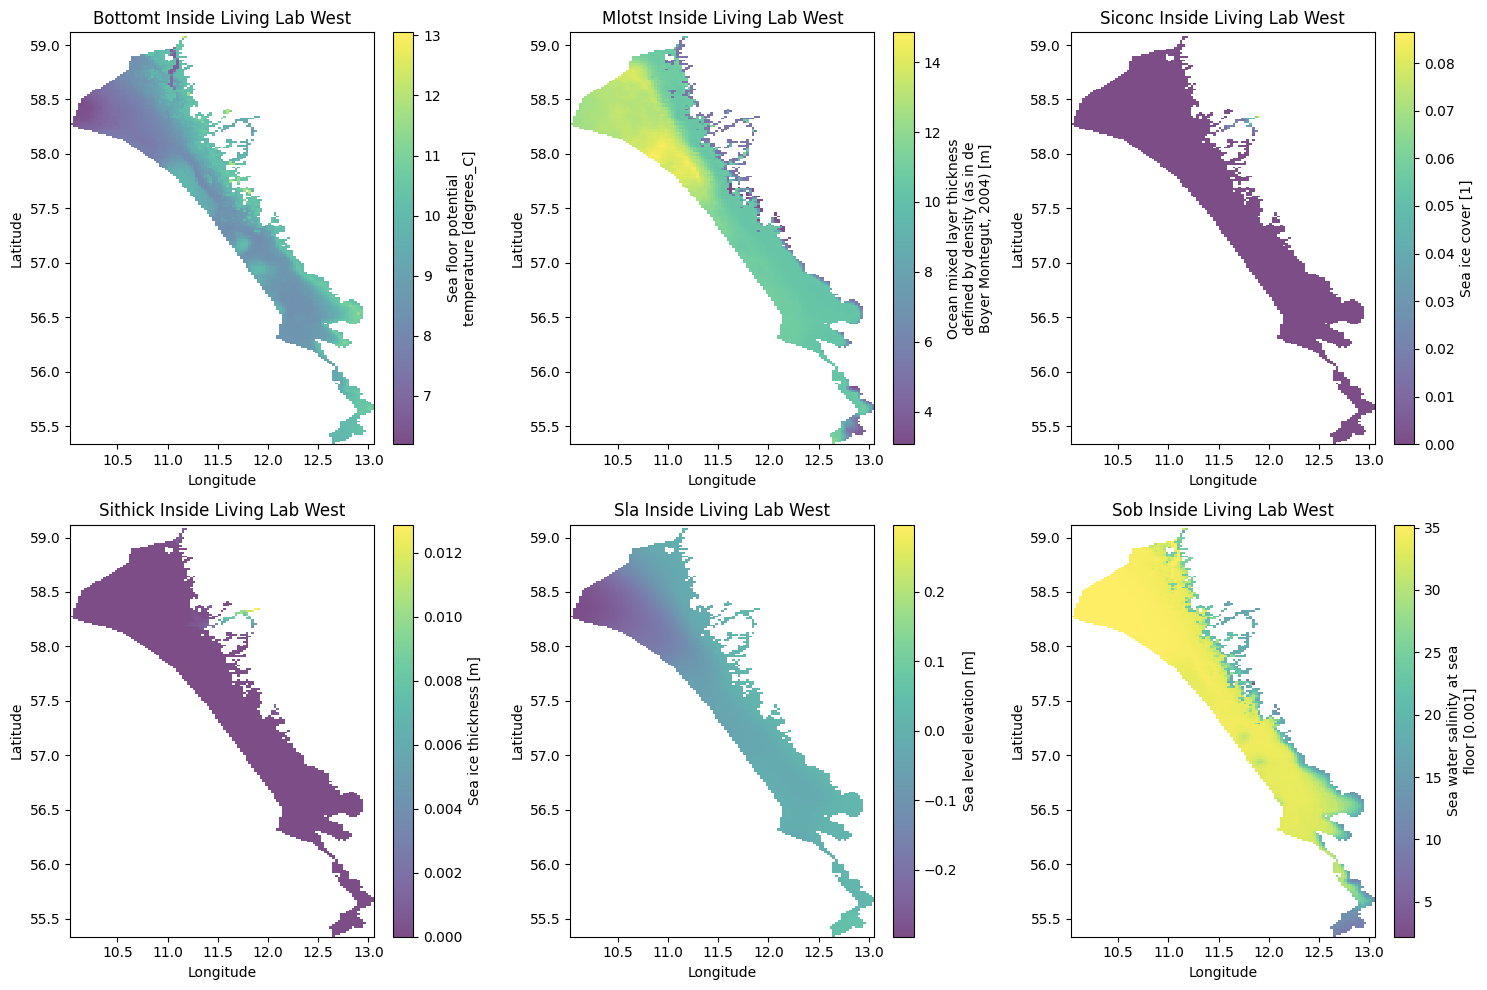

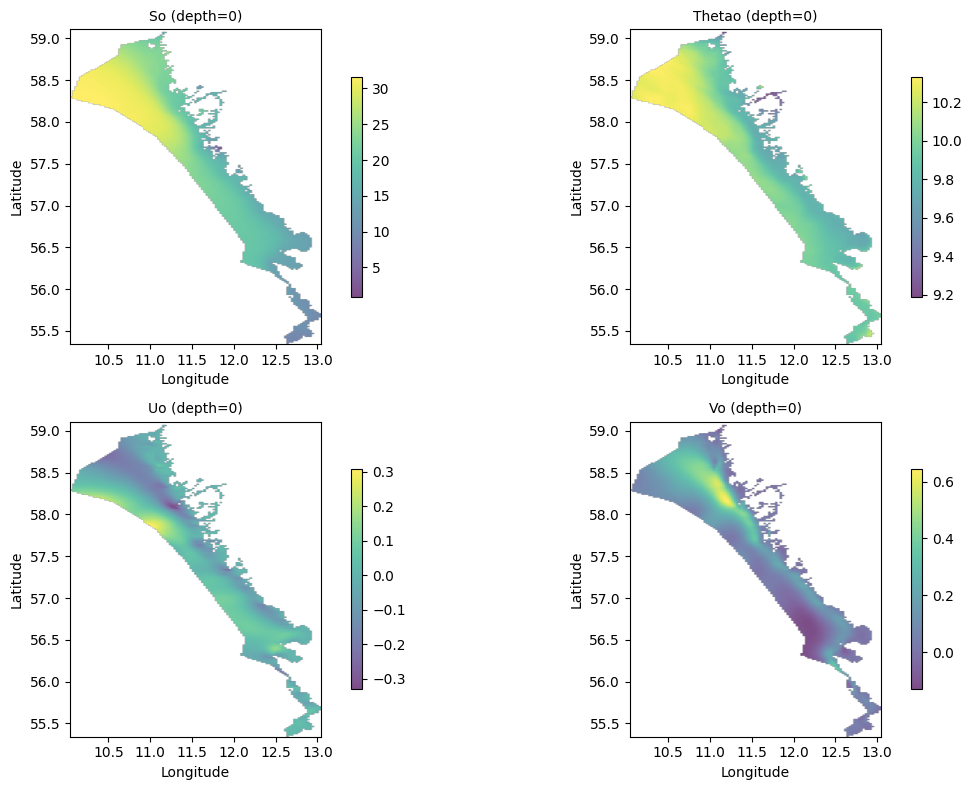

In [63]:
def plot_2D_variables_grid(var_names):
    n_vars = len(var_names)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for i, var_name in enumerate(var_names):
        data_filtered = filtered_data[var_name].isel(time=0)
        mappable = data_filtered.plot(ax=axes[i], cmap='viridis', alpha=0.7, add_colorbar=True)
        axes[i].set_title(f'{var_name.capitalize()} Inside Living Lab West', fontsize=12)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_2D_variables_grid(['bottomT', 'mlotst', 'siconc', 'sithick', 'sla', 'sob'])

def plot_3D_variables_grid(var_names):
    n_vars = len(var_names)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()
    for i, var_name in enumerate(var_names):
        data_filtered = filtered_data[var_name].isel(time=0)
        depth_data_filtered = data_filtered.isel(depth=0).squeeze()
        lat = depth_data_filtered.coords['lat'].values
        lon = depth_data_filtered.coords['lon'].values
        im = axes[i].imshow(depth_data_filtered, cmap='viridis', alpha=0.7, origin='lower',
                            extent=[lon.min(), lon.max(), lat.min(), lat.max()])
        fig.colorbar(im, ax=axes[i], shrink=0.7)
        axes[i].set_title(f'{var_name.capitalize()} (depth=0)', fontsize=10)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_3D_variables_grid(['so', 'thetao', 'uo', 'vo'])


Let's repeat the method for all the years and save the results. This step can be very long time.

In [66]:
for year in range(2015, 2024):
    input_file = f'BAL-MYP-NEMO_PHY-AnnualMeans-{year}.nc'
    output_file = f'filtered_{input_file}'

    ds = xr.open_dataset(input_file)
    lat = ds['lat'].values
    lon = ds['lon'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])
    mask = mask.reshape(lon_grid.shape)
    mask_da = xr.DataArray(mask, coords=[ds['lat'], ds['lon']], dims=["lat", "lon"])
    filtered_data = ds.where(mask_da, drop=True) 
    filtered_data.to_netcdf(output_file)
    print(f'Filtered data for {year} saved to {output_file}')

Filtered data for 2015 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2015.nc
Filtered data for 2016 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2016.nc
Filtered data for 2017 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2017.nc
Filtered data for 2018 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2018.nc
Filtered data for 2019 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2019.nc
Filtered data for 2020 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2020.nc
Filtered data for 2021 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2021.nc
Filtered data for 2022 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2022.nc
Filtered data for 2023 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2023.nc


### Filtering the Baltic Sea Biogeochemistry Reanalysis datset

This dataset is stuctured like the Baltic Sea Reanalysis datset, so we will use the same method. Let's open the dataset first and see the name of the variables.

In [68]:
input_file = 'BAL-MYP-ERGOM_BGC-AnnualMeans-2015.nc'
ds = xr.open_dataset(input_file)
ds

<xarray.Dataset> Size: 933MB
Dimensions:  (time: 1, depth: 56, lat: 774, lon: 763)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2015-07-01T06:00:00
Data variables:
    chl      (time, depth, lat, lon) float32 132MB ...
    nh4      (time, depth, lat, lon) float32 132MB ...
    no3      (time, depth, lat, lon) float32 132MB ...
    nppv     (time, depth, lat, lon) float32 132MB ...
    o2       (time, depth, lat, lon) float32 132MB ...
    o2b      (time, lat, lon) float32 2MB ...
    ph       (time, depth, lat, lon) float32 132MB ...
    po4      (time, depth, lat, lon) float32 132MB ...
    spco2    (time, lat, lon) float32 2MB ...
    zsd      (time, lat, lon) float32 2MB ...
Attributes: (12/22)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Sat Nov 09 21:06:27 2024: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2015-01-01 12:00:00
    NCO:                    netCDF Operators version 4.9.1 (Homepage = http:/...
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS ERGOM annual integrated model fields

In [69]:
for year in range(2015, 2024):
    input_file = f'BAL-MYP-ERGOM_BGC-AnnualMeans-{year}.nc'
    output_file = f'filtered_{input_file}'

    ds = xr.open_dataset(input_file)
    lat = ds['lat'].values
    lon = ds['lon'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])
    mask = mask.reshape(lon_grid.shape)
    mask_da = xr.DataArray(mask, coords=[ds['lat'], ds['lon']], dims=["lat", "lon"])
    filtered_data = ds.where(mask_da, drop=True) 
    filtered_data.to_netcdf(output_file)
    print(f'Filtered data for {year} saved to {output_file}')

Filtered data for 2015 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2015.nc
Filtered data for 2016 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2016.nc
Filtered data for 2017 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2017.nc
Filtered data for 2018 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2018.nc
Filtered data for 2019 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2019.nc
Filtered data for 2020 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2020.nc
Filtered data for 2021 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2021.nc
Filtered data for 2022 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2022.nc
Filtered data for 2023 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2023.nc
